In [46]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda
from keras.layers import Cropping2D,Convolution2D
from keras import regularizers
from keras import losses

In [47]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12225522018622924134, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 37748736
 locality {
   bus_id: 1
 }
 incarnation: 9064188908331637558
 physical_device_desc: "device: 0, name: GRID K520, pci bus id: 0000:00:03.0"]

### Read in data path

In [51]:
samples = [] # empty list to save data path

folder_path = "./data"
# extract image path
with open(folder_path+'/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
# samples = samples[:9284] # extract

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2) # train_samples and test_samples include path
print('number of training samples :,',len(train_samples))
print('number of validation samples :,',len(validation_samples))

number of training samples :, 8230
number of validation samples :, 2058


### Build generator to batch-process data

In [52]:
# use generator
def generator(samples,batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0,num_samples,batch_size):
            batch_samples = samples[offset:offset + batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                for i in range(0,2): # extract center, left and right camera images
                    name = './data/IMG/' + batch_sample[i].split("\\")[-1] # extract file name
                    image = plt.imread(name)
                    angle = float(batch_sample[3])
                    images.append(image)
                    angles.append(angle)
                    X_train = np.array(images)
                    y_train = np.array(angles)
            yield (X_train, y_train)
            
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples,batch_size=32)

### Build a neural network

Epoch 1/15
258/258 [==============================] - 54s 210ms/step - loss: 0.0448 - val_loss: 0.0401
Epoch 2/15
258/258 [==============================] - 52s 203ms/step - loss: 0.0414 - val_loss: 0.0368
Epoch 3/15
258/258 [==============================] - 52s 203ms/step - loss: 0.0408 - val_loss: 0.0373
Epoch 4/15
258/258 [==============================] - 52s 200ms/step - loss: 0.0399 - val_loss: 0.0363
Epoch 5/15
258/258 [==============================] - 52s 203ms/step - loss: 0.0392 - val_loss: 0.0369
Epoch 6/15
258/258 [==============================] - 52s 203ms/step - loss: 0.0390 - val_loss: 0.0369
Epoch 7/15
258/258 [==============================] - 52s 203ms/step - loss: 0.0382 - val_loss: 0.0366
Epoch 8/15
258/258 [==============================] - 52s 200ms/step - loss: 0.0371 - val_loss: 0.0359
Epoch 9/15
258/258 [==============================] - 52s 203ms/step - loss: 0.0361 - val_loss: 0.0350
Epoch 10/15
258/258 [==============================] - 53s 205ms/step - l

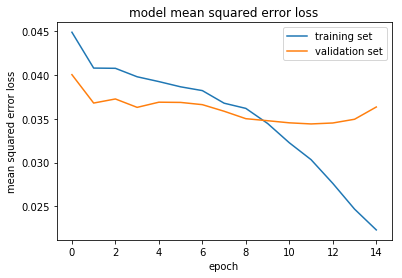

In [53]:
# ================================
# Build NN artitecture
# ================================
batch_size = 32
batches_per_epoch_train = len(train_samples)//batch_size + 1
batches_per_epoch_val = len(validation_samples)//batch_size + 1
# the current NN artitecture is based on Nvidia's paper End to End Learning for Self-Driving Cars
img_shape = (160,320,3)
model = Sequential()
model.add(Cropping2D(cropping=((50,20),(0,0)),input_shape=img_shape)) # crop off top 50 pixels and bottom 20 pixels
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=img_shape))
model.add(Convolution2D(24,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(36,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(48,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(64,(3,3),strides=(2,2),activation="relu"))
model.add(Convolution2D(64,(3,3),strides=(2,2),activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss=losses.mean_squared_error,optimizer='adam')

# ==========================================
# Build training and visualization pipeline
# ==========================================
history_object = model.fit_generator(train_generator, validation_data = validation_generator, 
                                     steps_per_epoch = batches_per_epoch_train,
                                     validation_steps = batches_per_epoch_val,
                                     epochs=15, verbose=1)

# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# save model
model.save('model.h5')
